# Convolutional Autoencoder

## Main Idea: Autoencoder Networks

In general, Autoencoders are a type of Artificial Neural Network used to learn efficient codings or latent space representations of data which can be applied to a wide variety of tasks such as dimensionality reduction, denoising, and anomaly detection. The Autoencoder framework comprises of two main components, the Encoder network and the Decoder network. The Encoder network aims to compress a given sample into an encoding containing information on the latent features by passing it through several layers. The Decoder network then takes this compressed representation and expands it in an attempt to reconstruct/approximate the original input. This process is done in a feedforward manner in which a loss function is used to assess model performance. Through backpropagation, the weights/learnable parameters are then updated to improve the models capability in obtaining the most suitable latent space representation over batches data for numerous epochs. 

## Autoencoders for Anomaly Detection

Anomaly detection is a machine learning task that aims to isolate anomalous/outlier events from normal instances. This task is suitable for our project because the population data we are dealing with are MRI scans of the brain. Our goal is to build a model that adequately learns the latent features that represent a healthy brain in the form of MRI scans. In this way, we train our autoencoder strictly on healthy brain MRI scans. Our training and validation sets will contain such images where we utilize the validation set to ensure that the model is not overfitting specifically on the training set. After training over several epochs, we then run our model through the testing data which includes only a small portion of MRI scans containing brain tumors. If doen correctly, our model will suffer in reconstructing the positive cases, resulting in a higher reconstruction error. The goal then is to determine the best threshold for separating the distribution of reconstruction errors for both the minority and majority classes for detection purposes. 

While we have access to ground truth labels for positive MRI results, in general this won't be the case if a given model were to be implemented in real time. It is important to note that without proper tuning, Autoencoders are susceptible to learning the so-called "identity function" on the training set rather than useful representations of the input data when minimizing the loss function during training. This can be mitigated by adding some regularization constraint on the loss function.


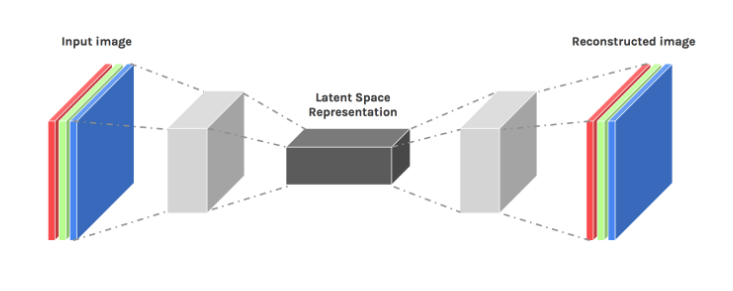

## Image Convolutions

In ComputerVision, the convolution operation is widely used to create a feature map over a given input by applying kernel/filter of fixed size across each element/pixel. In this sense, we are dealing with 2D Convolutions. The image below showcases an example of applying 2D convolutions of some arbitrary matrix given the 3x3 kernel shown below. Parameters such as kernel size, stride (filter step size), and padding (adding pixel values of 0 along the border of the image) all play a key role in determining the output of the convolution operation. In the scope of deep learning, the filter values used to perform such convolutions at each layer are the learned parameters that are updated through backpropagation. 

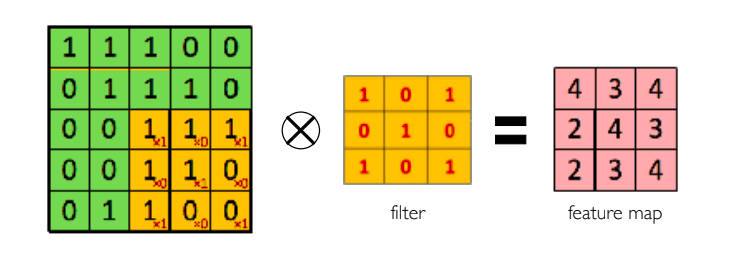

For the Encoder Network, we will stack several 2D Convolution layers with increasing kernel size to obtain the compressed representation of each image/batches of images. 

On the other hand, the Decoder Network utilizes 2D Transposed Convolution operations to reconstruct the images. In contrast to the regular convolution that reduces input elements via the kernel, the transposed convolution broadcasts input elements via the kernel, thereby producing an output that is larger than the input. For example, given an n x n input tensor, and a k x k kernel, sliding the kernel window with a stride of 1 will result in an output matrix of shape (n + k -1) x (n + k - 1). The example below provides a visualization of the Transposed Convolution operation.

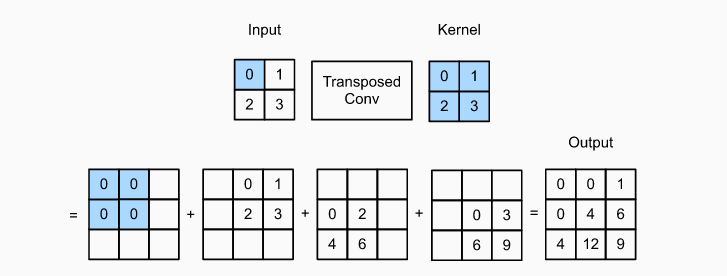

After brielfy introducing the overall framework of Convolutional Autoencoders, we move forward in our implementation of our model. For this aspect of our project, we will utilize PyTorch for modeling and data processing.

In [ ]:
!pip install torchinfo
!pip install pytorch-msssim

In [ ]:
import os  
import glob
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF 
from sklearn.metrics import roc_curve, auc, classification_report

import PIL 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import Image

# torch-based imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary 
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pytorch_msssim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [ ]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
main_path = '/content/drive/MyDrive/Academic/Spring 2022/MA 544 Linear Algebra/Anomaly-Detection-Numerical-LinAlg-for-Big-Data/MRIscans'

train_path =  main_path + '/Training/'
val_path = main_path + '/Validation/'
test_path = main_path + '/Testing/'

train_files = glob.glob(os.path.join(train_path, "no_tumor_train",'*.*'))
val_files = glob.glob(os.path.join(val_path, "no_tumor_val", "*.*"))

test_files_pos = glob.glob(os.path.join(test_path, 'extra_tumor_imgs', '*.*'))[:100]
test_files_neg = glob.glob(os.path.join(test_path, 'no_tumor', '*.*'))
test_files = test_files_pos + test_files_neg

test_labels = np.array([1]*len(test_files_pos)+[0]*len(test_files_neg))

In [ ]:
len(test_files_neg)

738

In [ ]:
print(f'Number of training files: {len(train_files)}')
print(f'Number of validation files: {len(val_files)}')
print(f'Number of test files: {len(test_files)}')

print(f'\nNumber of tumor images in test set: {len(test_files_pos)}')
print(f'Number of non-tumor images in test set: {len(test_files_neg)}')

Number of training files: 1841
Number of validation files: 399
Number of test files: 838

Number of tumor images in test set: 100
Number of non-tumor images in test set: 738


## Dataset Class

Our dataset class is our primary construct for loading images for modeling. This allows us to load and process images only when called upon rather than storing each image in memory before training or testing. This results in a substantial improvement in runtime when coupled with GPU efficiency. The class is also structured such that custom transformations and augmentations can be applied to the images for preprocessing before modeling.

The default transformations applied to each image are as follows:

* Convert each image to grayscale
* Transform images into tensor format and normalize pixel values
* Rescale image to 250 x 250 resolution

In [ ]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, test=False, labels=None, img_transforms=None, grayscale=True):
        
        self.img_path = img_path
        self.test = test 
        self.labels = labels 

        # Default Transforms
        if img_transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((250, 250)),
                                                  ])
        # Custom Transforms
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load images
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('L')
        cur_img = self.transforms(cur_img)

        if self.test:
            return cur_img, self.labels[index]

        else:
            return cur_img
    
    def __len__(self):
        return len(self.img_path)

## Preprocessing Functions

In [ ]:
class randSVD_recon(object):
    
    def __call__(self, img):

        k = 35

        img_height, img_width = img.shape[1], img.shape[2]
        img = np.asarray(img).reshape(img_height, img_width)
        
        U, S, V = randomized_svd(img, n_components=k, random_state=0)
        recon = np.dot(U[:,:k], V[:k,:] * S[:k].reshape(k,1))

        recon = torch.Tensor(recon).reshape(1, img_height, img_width)

        return recon

    def __repr__(self):
        return self.__class__.__name__+'()'


class NMF_reconstruction(object):

    def __init__(self, n_comp = 35):
        self.n_comp = n_comp

    def __call__(self, img):


        img_height, img_width = img.shape[1], img.shape[2]
        img = np.asarray(img).reshape(img_height, img_width)

        estimator = NMF(n_components = self.n_comp, init='random', tol=0.01, max_iter=500)
        W = estimator.fit_transform(img)
        H = estimator.components_ 

        NMF_img = np.dot(W, H)
        NMF_img = torch.Tensor(NMF_img).reshape(1, img_height, img_width)

        return NMF_img 

    def __repr__(self):
        return self.__class__.name__ + '{}'

## Initial Architecture

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 96, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 64, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1,output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.float()
        x = self.decoder(x)
        return x

### CNN Autoencoder Training Function
---
####Loss Function:

**Mean Squared Error:**

$$\textbf{MSE} = \frac{1}{n} \Sigma_{i=1}^n (Y_i - \hat{Y_i})^2$$

Where:
* n = number of samples per batch
* $Y_i$ = target variable
* $\hat{Y_i}$ = predicted value/model output

In order to tune model performance, we can also impose a regularization constraint such as L2 or L1 regularization onto our loss function to reduce overfitting.


**SSIM (Structural Similarity Index Measure**

Another loss function considered but not utilized for this project was teh SSIM (Structural Similarity Index Measure) index. It is a measure of the similarity between two image which could be useful for image reconstruction. Since it is a similarity measure, values close to 1 indicate high similarity. Therefore, we would subtract that value from 1 in order to obtain the loss value at each step:

$$\textbf{Loss} = 1 - SSIM(x, y) = 1 - \frac{(2\mu_x\mu_y + c_1)(2\sigma_{xy}+c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

Where:
* $\mu_x, mu_y$ are the mean pixel values for the target and observed images
* $\sigma_x^2, \sigma_y^2$ are the variance of the target and observed pixel values
* $\sigma_{xy}$ is the covariance of x and y
* $c_1, c_2$ are stabilization factors

While this loss function was considered, we opted against the use of it due to the inherent similarity between MRI scans resulting in exteremely low loss values decreasing the margin of separation between reconstruction of the minority and majority classes.



---
####Optimization Algorithm:

**Adam: ADAptive Moments Algorithm**

The Adam optimization algorithm is an apdaptation of the gradient descent algorithm that takes into account momentum with bias correction terms to handle non-convex settings. 

For a given prediction $\mathbf{x}^{(i)}$ and target $\mathbf{y}^{(i)}$ from the training set:

* Compute the gradient estimate:  $$\hat{\mathbf{g}} \leftarrow + \nabla_{\theta}L(f(\mathbf{x}^{(i)};\theta), \mathbf{y}^{(i)})$$
* Update the bias terms: $$\mathbf{s} \leftarrow \rho_1\mathbf{s} + (1-\rho_1)\hat{\mathbf{g}}$$
$$\mathbf{r} \leftarrow \rho_2\mathbf{r} + (1-\rho_2)\hat{\mathbf{g}}\odot\hat{\mathbf{g}}$$
* Correct bias terms: $$\hat{\mathbf{s}}\leftarrow \frac{\mathbf{s}}{1-\rho_1^t}, \hat{\mathbf{r}}\leftarrow \frac{\mathbf{r}}{1-\rho_2^t}$$
* Compute update for learnable parameters: $$\Delta \theta = -\epsilon \frac{\hat{\mathbf{s}}}{\sqrt{\hat{\mathbf{r}}} + \delta}$$
* Apply Parameter Update: $$\theta \leftarrow \theta + \Delta \theta$$

Where:
* $\epsilon$ is the learning rate
* $\rho_1$ and $\rho_2$ are the decay rates
* $\delta$ is a bias term to avoid vanishing gradient (divide by zero in parameter update)

This process is repeated across several epochs (iterations across the entire dataset) in which the learnable parameters at each layer are updated until convergence/stopping criteria is met.


In [ ]:
def train_model(model, train_dataset, val_dataset, device, lr=0.0001, 
                l2=0, epochs=30, batch_size=32, num_workers=4):
    
    model = model.to(device)
    
    # construct dataloader to iterate through batches of images
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # history
    history = {'train_loss': [],
               'val_loss': []}            
    
    # set up loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    criterion = nn.MSELoss()
    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        val_loss = 0

        for i, images in enumerate(train_loader):
            images = images.to(device)
            
            outputs = model(images)
            #cur_train_loss = 1 - pytorch_msssim.ssim(images, outputs)
            cur_train_loss = criterion(images, outputs)
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

            # loss
            train_loss += cur_train_loss 
            
        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for i, images in enumerate(val_loader):
                # calculate validation loss
                images = images.to(device)

                outputs = model(images)
                
                # loss
                #cur_valid_loss = 1-pytorch_msssim.ssim(images, outputs)
                cur_valid_loss = criterion(images, outputs)
                val_loss += cur_valid_loss

        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f}, val loss:{val_loss:.5f}")
        
        # update history
        
        history['train_loss'].append(train_loss.cpu().item())
        history['val_loss'].append(val_loss.cpu().item())
    
    return history

### Extraction of Reconstruction Errors on Test Set

In [ ]:
def get_reconstruction_err(test_data, model):
    
    error = {'pred_loss':[], 'label':[]}
    criterion = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)
        
        for image_, label in test_loader:
            image_ = image_.to(device)
            outputs = model(image_)
            #loss = 1 - pytorch_msssim.ssim(image_, outputs)
            loss = criterion(image_, outputs)
            error['pred_loss'].append(loss.cpu().item())
            error['label'].append(label.cpu().item())

    recon_err = pd.DataFrame(error)
    
    return recon_err

### Plotting Classification Results

After extracting the reconstruction errors from the test set, we apply the set of errors alongside the ground truth labels into the roc_curve function in order to compute the Receiver Operating Characteristic metric. This outputs a set of false positive rate, true prositive rate, and thresholds defining the decision boundary related to each FPR and TPR calculation associated with classification.

$$\textbf{TPR} = \frac{\textbf{TP}}{\textbf{TP} + \textbf{FN}}$$

$$\textbf{FPR} = \frac{\textbf{FP}}{\textbf{FP} + \textbf{TN}}$$

With the set of FPR and TPR values, we take the threshold that maximizes the difference between the TPR and FPR as our decision boundary for classification. Once this is done, we plot the distribution of reconstruction errors for each class and along with the ROC Curve to assess our results.

Finally, using the threshold as our decision boundary, we assign predicted labels to all of the test samples and generate a classification report to assess our results.



In [ ]:
def test_analysis(recon_err, verbose=True):
    '''
    Main function to analyze test results.

    Functionalities:
      - Calculate FPR and TPR based on reconstruction loss
      - Construct Receiver Operator Characteristic Curve and calculate area under the curve
      - Use TPR and FPR to find the best reconstruction threshold for classification
      - Classify images based on decision boundary
      - Plot all relevant figures for reconstruction

    '''
    fpr, tpr, thresholds = roc_curve(recon_error.label , recon_error.pred_loss)
    roc_auc = auc(fpr, tpr)

    best_thres_idx = np.argmax(tpr-fpr)
    best_thres = thresholds[best_thres_idx]

    recon_error['Pred'] = np.where(recon_error['pred_loss'] <= best_thres, 0, 1)

    if verbose:
        print(f'Best threshold for classification: {best_thres}\n')
        

        sns.displot(recon_error, x='pred_loss',kde=True, hue='label', bins=40, log_scale=[True, False], height=6, aspect=8/6, edgecolor='white')
        
        plt.figure(figsize=(11,6))
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], 'r--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title(f'Reciever Operating Characteristic Curve -- AUC: {roc_auc:.3f}')
        plt.show()

    return recon_error

##Initial Model 

We begin our implementation of the Convolutional Autoencoder algorithm by training the model under limited preprocessing. As a default setting, we only normalize pixel intensity and resize our images to 250 x 250 resolution

In [ ]:
train_dataset = CT_Dataset(img_path=train_files)
val_dataset = CT_Dataset(img_path=val_files)

In [ ]:
model = Autoencoder()
print(summary(model, (32, 1, 250, 250))) # shape --> (batch size, num_channels, img_height, img_width)
hist = train_model(model, train_dataset, val_dataset, device, batch_size=64, epochs=15, lr=0.001)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              --                        --
├─Sequential: 1-1                        [32, 96, 57, 57]          --
│    └─Conv2d: 2-1                       [32, 32, 125, 125]        320
│    └─ReLU: 2-2                         [32, 32, 125, 125]        --
│    └─Conv2d: 2-3                       [32, 64, 63, 63]          18,496
│    └─ReLU: 2-4                         [32, 64, 63, 63]          --
│    └─Conv2d: 2-5                       [32, 96, 57, 57]          301,152
├─Sequential: 1-2                        [32, 1, 250, 250]         --
│    └─ConvTranspose2d: 2-6              [32, 64, 63, 63]          301,120
│    └─ReLU: 2-7                         [32, 64, 63, 63]          --
│    └─ConvTranspose2d: 2-8              [32, 32, 125, 125]        18,464
│    └─ReLU: 2-9                         [32, 32, 125, 125]        --
│    └─ConvTranspose2d: 2-10             [32, 1, 250, 250]        

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff39dd9f560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff39dd9f560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:14 / 15, train loss:0.00206, val loss:0.00284
Epoch:15 / 15, train loss:0.00203, val loss:0.00264


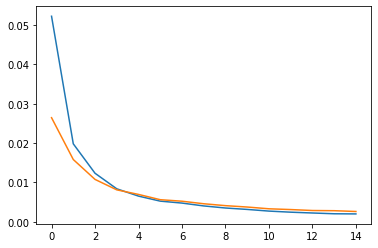

In [ ]:
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.show()

In [ ]:
test_dataset = CT_Dataset(test_files, test=True, labels=test_labels)
recon_error = get_reconstruction_err(test_dataset, model)

Results from the initial model suggests an over generalization over the normal class of images. Our model achieves an F1-Score of 0.93 on the non-tumorous class. However, our model struggles to correctly identify positive cases achieving an F1-score of 0.47 on the tumor class.

Best threshold for classification: 0.004554661922156811



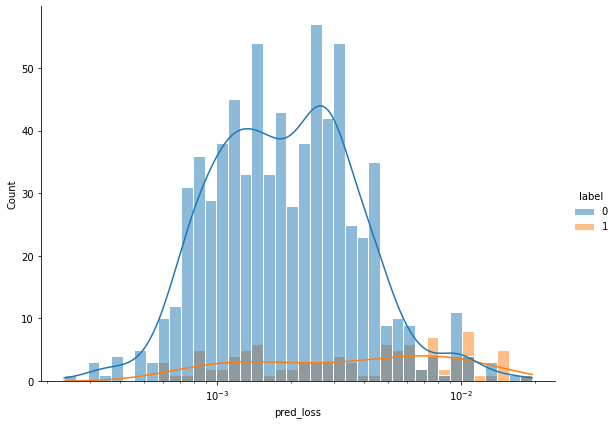

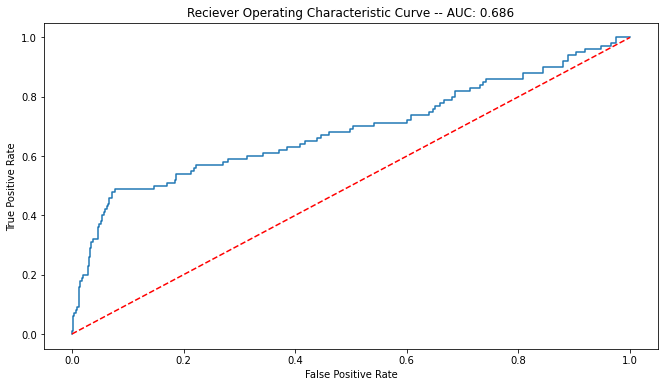



              precision    recall  f1-score   support

           0       0.93      0.92      0.93       738
           1       0.46      0.48      0.47       100

    accuracy                           0.87       838
   macro avg       0.69      0.70      0.70       838
weighted avg       0.87      0.87      0.87       838



In [ ]:
recon_error = test_analysis(recon_error)

print('\n')
print(classification_report(recon_error['label'], recon_error['Pred']))

## Custom Transformations

Next, we apply both Randomized SVD and Non-negative Matrix Factorization to our preprocessing pipeline and discuss its effect on model performance. The idea is to achieve a low-rank representation of the data that preserves information regarding the features that best describe brain structure. This in turn should prove to be beneficial for feature extraction in the image reconstruction process

### Randomized SVD

In [ ]:
custom_trans_SVD = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((250, 250)),
                                       randSVD_recon()])

train_dataset = CT_Dataset(img_path=train_files, img_transforms=custom_trans_SVD)
val_dataset = CT_Dataset(img_path=val_files, img_transforms=custom_trans_SVD)

In [ ]:
model = Autoencoder()
hist = train_model(model, train_dataset, val_dataset, device, batch_size=30, epochs=10)

Training Start:
Epoch:1 / 10, train loss:0.06249, val loss:0.03026
Epoch:2 / 10, train loss:0.02460, val loss:0.02168
Epoch:3 / 10, train loss:0.01727, val loss:0.01474
Epoch:4 / 10, train loss:0.01083, val loss:0.00992
Epoch:5 / 10, train loss:0.00774, val loss:0.00794
Epoch:6 / 10, train loss:0.00631, val loss:0.00673
Epoch:7 / 10, train loss:0.00537, val loss:0.00593
Epoch:8 / 10, train loss:0.00465, val loss:0.00526
Epoch:9 / 10, train loss:0.00411, val loss:0.00484
Epoch:10 / 10, train loss:0.00376, val loss:0.00440


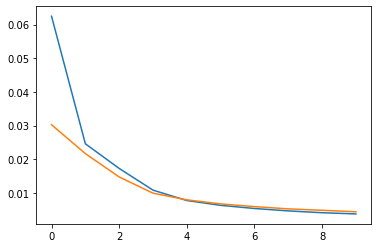

In [ ]:
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.show()

In [ ]:
test_dataset = CT_Dataset(test_files, test=True, labels=test_labels, img_transforms=custom_trans_SVD)
recon_error = get_reconstruction_err(test_dataset, model)

After applying Randomized SVD for preprocessing, we see that the model decreases in performance. From the distribtuion plot below, we see that the reconstruction errors between the two classes appear to follow the same distribution. 

Best threshold for classification: 0.005500320345163345



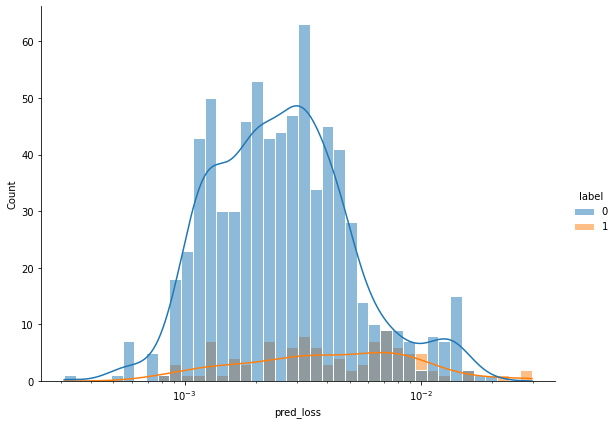

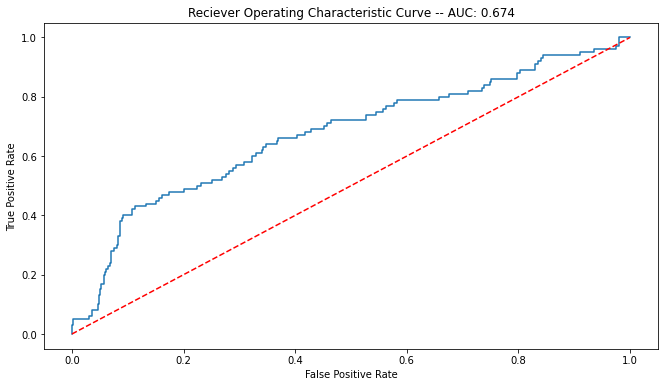



              precision    recall  f1-score   support

           0       0.92      0.89      0.90       738
           1       0.33      0.42      0.37       100

    accuracy                           0.83       838
   macro avg       0.63      0.65      0.64       838
weighted avg       0.85      0.83      0.84       838



In [ ]:
recon_error = test_analysis(recon_error)
print('\n')
print(classification_report(recon_error['label'], recon_error['Pred']))

### Non-negative Matrix Factorization

In [ ]:
custom_trans_NMF = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((250, 250)),
                                       NMF_reconstruction()])

train_dataset_NMF = CT_Dataset(img_path=train_files, img_transforms=custom_trans_NMF)
val_dataset_NMF = CT_Dataset(img_path=val_files, img_transforms=custom_trans_NMF)

In [ ]:
model = Autoencoder()
#summary(model, (32, 1, 250, 250)) # shape --> (batch size, num_channels, img_height, img_width)
hist_NMF = train_model(model, train_dataset_NMF, val_dataset_NMF, device, batch_size=30, epochs=10)

Training Start:


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:1 / 10, train loss:0.09279, val loss:0.03453


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:2 / 10, train loss:0.02744, val loss:0.02157


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/

Epoch:3 / 10, train loss:0.01624, val loss:0.01294


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:4 / 10, train loss:0.00994, val loss:0.00894


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:5 / 10, train loss:0.00732, val loss:0.00732
Epoch:6 / 10, train loss:0.00599, val loss:0.00616


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:7 / 10, train loss:0.00514, val loss:0.00547


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/

Epoch:8 / 10, train loss:0.00453, val loss:0.00493


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:9 / 10, train loss:0.00416, val loss:0.00464
Epoch:10 / 10, train loss:0.00376, val loss:0.00415


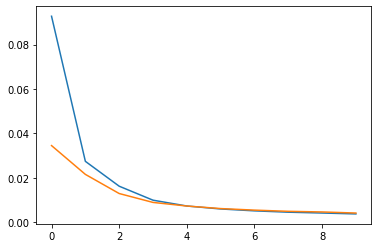

In [ ]:
plt.plot(hist_NMF['train_loss'])
plt.plot(hist_NMF['val_loss'])
plt.show()

In [ ]:
test_dataset_NMF = CT_Dataset(test_files, test=True, labels=test_labels, img_transforms=custom_trans_NMF)
recon_error = get_reconstruction_err(test_dataset_NMF, model)

After applying NMF, it is clear that model performance suffers the most under this configuration. This may suggest that further tuning for both the Randomized SVD and NMF definitions must be explored for future work. The wide variety of MRI brain images may prove to mitigate the role that these preprocessing functions may have played in our model pipeline. It is an area of interest for us to compile a dataset of unifrom MRI images of the same orientation and revisit these methods once again.

Best threshold for classification: 0.005506176967173815



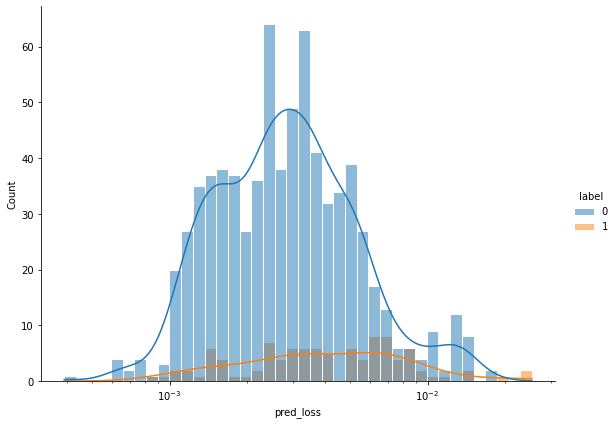

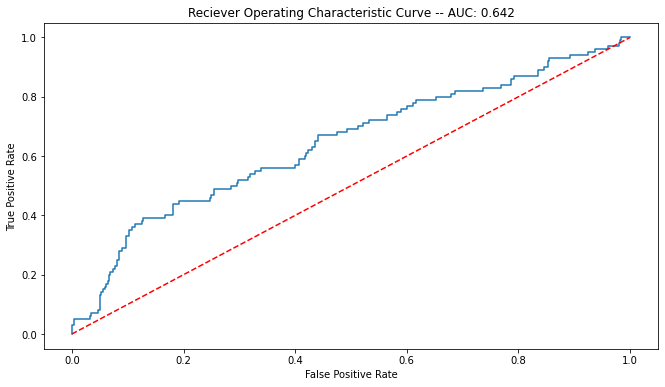

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       706
           1       0.38      0.29      0.33       132

    accuracy                           0.81       838
   macro avg       0.63      0.60      0.61       838
weighted avg       0.80      0.81      0.80       838



In [ ]:
recon_error = test_analysis(recon_error)

print(classification_report(recon_error['Pred'], recon_error['label']))